In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/training-pt/yolov7_training.pt
/kaggle/input/pcb-dat/pcb_det.yaml
/kaggle/input/pcb-defects/PCB_DATASET/rotate.py
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/10.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/01.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/09.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/05.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/06.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/04.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/12.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/11.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/08.JPG
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/07.JPG
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Mouse_bite/01_mouse_bite_11.xml
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Mouse_bite/01_mouse_bite_17.xml
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Mouse_bite/08_mouse_bite_08.xml
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Mouse_bite/08_mouse_bite_02.xml
/kag

In [2]:
!cp -R /kaggle/input/pcb-defects/PCB_DATASET/Annotations/ /kaggle/working/Annotations
!cp -R /kaggle/input/pcb-defects/PCB_DATASET/images/ /kaggle/working/Images
# !cp -R /kaggle/input/pcb-defects/PCB_DATASET/images/ /kaggle/working/images

# import shutil


In [3]:
# os.mkdir("/kaggle/working/Images")
import os
source_folder = "/kaggle/working/Images"
# destination_folder = "/kaggle/working/Images"
en=0
for file in os.listdir(source_folder):
    en+= len(os.listdir(os.path.join(f"{source_folder}/{file}")))
en
        

693

In [4]:
import os
import shutil
def add_path(source_folder, destination_folder):
    os.mkdir(destination_folder)
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            source_path = os.path.join(root, file)
            destination_path = os.path.join(destination_folder, file)
            shutil.move(source_path, destination_path)
#             os.remove(source_folder)


In [5]:
source_folder = "/kaggle/working/Images"
destination_folder = "/kaggle/working/images"
add_path(source_folder, destination_folder)
len(os.listdir("/kaggle/working/images"))

693

In [6]:
source_folder = "/kaggle/working/Annotations"
destination_folder = "/kaggle/working/annotations"
add_path(source_folder, destination_folder)
len(os.listdir("/kaggle/working/annotations"))

693

In [7]:
# !pip install Ipython
import torch
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [8]:
cat /kaggle/input/pcb-defects/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_01.xml

<annotation>
	<folder>Missing_hole</folder>
	<filename>01_missing_hole_01.jpg</filename>
	<path>/home/weapon/Desktop/PCB_DATASET/Missing_hole/01_missing_hole_01.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>3034</width>
		<height>1586</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>missing_hole</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>2459</xmin>
			<ymin>1274</ymin>
			<xmax>2530</xmax>
			<ymax>1329</ymax>
		</bndbox>
	</object>
	<object>
		<name>missing_hole</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1613</xmin>
			<ymin>334</ymin>
			<xmax>1679</xmax>
			<ymax>396</ymax>
		</bndbox>
	</object>
	<object>
		<name>missing_hole</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1726</xmin>
			<ymin>794</ymin>
			<xmax>1797</xmax>
			<

In [9]:
def extract_info_xml(xml_file):
    root=ET.parse(xml_file).getroot()
    info_dict={}
    info_dict["bboxes"]=[]
    for elem in root:
        if elem.tag=="filename":
            info_dict["filename"]=elem.text
        elif elem.tag=="size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
                
            info_dict["image_size"]=tuple(image_size)
        
        elif elem.tag=="object":
            bbox={}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"]=subelem.text
                elif subelem.tag=="bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag]=int(subsubelem.text)
            info_dict["bboxes"].append(bbox)
    return info_dict
            

In [10]:
print(extract_info_xml("/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_01.xml"))

{'bboxes': [{'class': 'missing_hole', 'xmin': 2459, 'ymin': 1274, 'xmax': 2530, 'ymax': 1329}, {'class': 'missing_hole', 'xmin': 1613, 'ymin': 334, 'xmax': 1679, 'ymax': 396}, {'class': 'missing_hole', 'xmin': 1726, 'ymin': 794, 'xmax': 1797, 'ymax': 854}], 'filename': '01_missing_hole_01.jpg', 'image_size': (3034, 1586, 3)}


In [11]:
mapping = {
    "missing_hole":0,
    "mouse_bite": 1,
    "open_circuit": 2,
    "short": 3,
    "spur":4,
    "spurious_copper":5
}

def convert_to_yolov5_format(info_dict):
    print_buffer=[]
    
    for b in info_dict["bboxes"]:
        try:
            class_id = mapping[b["class"]]
        except KeyError:
            print("Invalid Class.......")
        
        b_center_x = (b["xmin"] + b["xmax"]) / 2  
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x/=image_w
        b_center_y/=image_h
        b_width/=image_w
        b_height/=image_h
        
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
    
    save_file = os.path.join(f"/kaggle/working/labels/", info_dict["filename"].replace("jpg","txt"))
    print("\n".join(print_buffer), file=open(save_file, "w"))

In [12]:
os.mkdir("/kaggle/working/labels")
annotations = [os.path.join("/kaggle/working/annotations", x) for x in os.listdir("/kaggle/working/annotations") if x[-3:]=="xml"]
# annotations.sort()

for ann in tqdm(annotations):
    info_dict = extract_info_xml(ann)
    convert_to_yolov5_format(info_dict)
annotations = [os.path.join("/kaggle/working/labels", x) for x in os.listdir("/kaggle/working/labels") if x[-3:]=="txt"]

100%|██████████| 693/693 [00:00<00:00, 4620.95it/s]


In [13]:
print(len(os.listdir("/kaggle/working/labels")))
annotations = [os.path.join("/kaggle/working/labels", x) for x in os.listdir("/kaggle/working/labels") if x[-3:]=="txt"]
# print(annotations)

693


/kaggle/working/images/12_mouse_bite_08.jpg /kaggle/working/labels/12_mouse_bite_08.txt


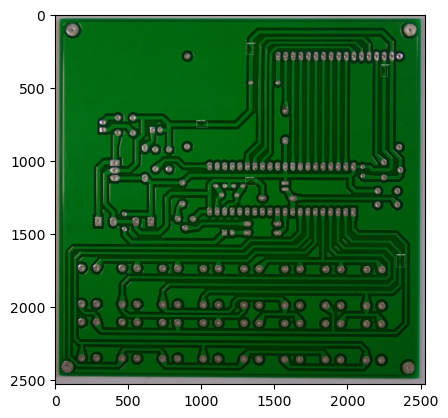

In [14]:
random.seed(10000)
class_id_to_name = dict(zip(mapping.values(), mapping.keys()))

def plot_bbox(img, ann_list):
    annotations = np.array(ann_list)
    w,h = img.size
    
    plotted_img = ImageDraw.Draw(img)
    
    plotted_image = ImageDraw.Draw(img)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)))
        plotted_image.text((x0, y0-10), class_id_to_name[(int(obj_cls))])
    plt.imshow(np.array(img))
    plt.show()

annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    ann_list = file.read().split("\n")[:-1]
    ann_list = [x.split(" ") for x in ann_list]
    ann_list = [[float(y) for y in x] for x in ann_list]

img_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
print(img_file, annotation_file)
assert os.path.exists(img_file)
img = Image.open(img_file)
plot_bbox(img, ann_list)

In [15]:
list_img=os.listdir('/kaggle/working/images')
images = [os.path.join("/kaggle/working/images", x) for x in list_img]
annotations = [os.path.join("/kaggle/working/labels", x) for x in os.listdir("/kaggle/working/labels") if x[-3:]=="txt"]
images.sort()
annotations.sort()
# print(len(annotations))
train_images, val_images, train_ann, val_ann = train_test_split(images, annotations, test_size=0.2, random_state=42)
val_images, test_image,val_ann, test_ann = train_test_split(val_images, val_ann, test_size=0.5, random_state=42)

In [16]:
# !mkdir /kaggle/working/road-sign-detection/images
!mkdir /kaggle/working/images/train /kaggle/working/images/val /kaggle/working/images/test

In [17]:
!mkdir /kaggle/working/labels/train /kaggle/working/labels/val /kaggle/working/labels/test

In [18]:
def move_files_to_folder(list_files, destination):
    for f in list_files:
        try:
            shutil.move(f, destination)
        except:
            print(f)
            assert False
            
move_files_to_folder(train_images, "/kaggle/working/images/train")
move_files_to_folder(val_images, "/kaggle/working/images/val")
move_files_to_folder(test_image, "/kaggle/working/images/test")

move_files_to_folder(train_ann, "/kaggle/working/labels/train")
move_files_to_folder(val_ann, "/kaggle/working/labels/val")
move_files_to_folder(test_ann, "/kaggle/working/labels/test")

In [19]:
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1185, done.
remote: Total 1185 (delta 0), reused 0 (delta 0), pack-reused 1185
Receiving objects: 100% (1185/1185), 74.23 MiB | 31.41 MiB/s, done.
Resolving deltas: 100% (512/512), done.


In [20]:
import yaml

with open(r'/kaggle/input/pcb-dat/pcb_det.yaml') as file:
    list = yaml.load(file, Loader=yaml.FullLoader)
    print(list)

{'train': '/kaggle/working/images/train', 'val': '/kaggle/working/images/val', 'test': '/kaggle/working/images/test', 'nc': 6, 'names': ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']}


In [21]:
# !python /kaggle/working/yolov7/train.py --img 640 --cfg /kaggle/working/yolov7/cfg/training/yolov7.yaml --hyp /kaggle/working/yolov7/data/hyp.scratch.custom.yaml --batch 8 --epochs 100 --data /kaggle/input/pcb-dat/pcb_det.yaml  --weights /kaggle/input/training-pt/yolov7_training.pt  --workers 24 --name pcb_det

In [22]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")
wandb.login(key = secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [23]:
!python /kaggle/working/yolov7/train.py --img 640 --cfg /kaggle/working/yolov7/cfg/training/yolov7.yaml --hyp /kaggle/working/yolov7/data/hyp.scratch.custom.yaml --batch 8 --epochs 100 --data /kaggle/input/pcb-dat/pcb_det.yaml  --weights /kaggle/input/training-pt/yolov7_training.pt  --workers 24 --name pcb_det

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso